## Multinomial Logistic Regression and Multi-layer Perceptrons

Author: Tanish Bafna\
Email: tab530@nyu.edu

### Setup

In [1]:
# Helper Functions
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')

# Data Libraries
import numpy as np
import pandas as pd

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout

### Data Preprocessing

The [Fashion-MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset is a collection of Zalando's article images, comprising 60,000 training and 10,000 test examples; each a 28x28 grayscale image representing one of 10 types of clothing items. This variety makes it an ideal multi-class classification problem for testing out different ML models. Since Fashion-MNIST is more complex than the original MNIST (digit recognition problem) but not as large as other high-resolution image datasets, it serves as a great feasible dataset for benchmarking.

The use of image recognition in economic research is also gaining traction. Academics are increasingly turning to satellite imagery for detailed insights including — analysis of soil and vegetation types, rooftop structures which indicate a household's economic status, and urbanization levels. Furthermore, the study of night lights is a very popular tool to understand aspects of development economics.

We begin by loading and preprocessing the image data to get it ready for training and evaluation.

In [ ]:
# Load Data
train = pd.read_csv('FashionMNIST/fashion-mnist_train.csv')
test = pd.read_csv('FashionMNIST/fashion-mnist_test.csv')

X_train = train.iloc[:,1:785].values
X_test = test.iloc[:,1:785].values

y_train = train.iloc[:,0].values
y_test = test.iloc[:,0].values

In [4]:
# Explatory Data Analysis
print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}', end='\n\n')

train.head()

Train: (60000, 784)
Test: (10000, 784)



,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each pixel takes on a value between 0 and 255, with 0 being black and 255 being white. Since the image size is 28 x 28 px, there are a total of 784 features that can use used for training an ML model and teaching it to identify types of clothing from images. The distribution of the images over the 10 categories is equal:

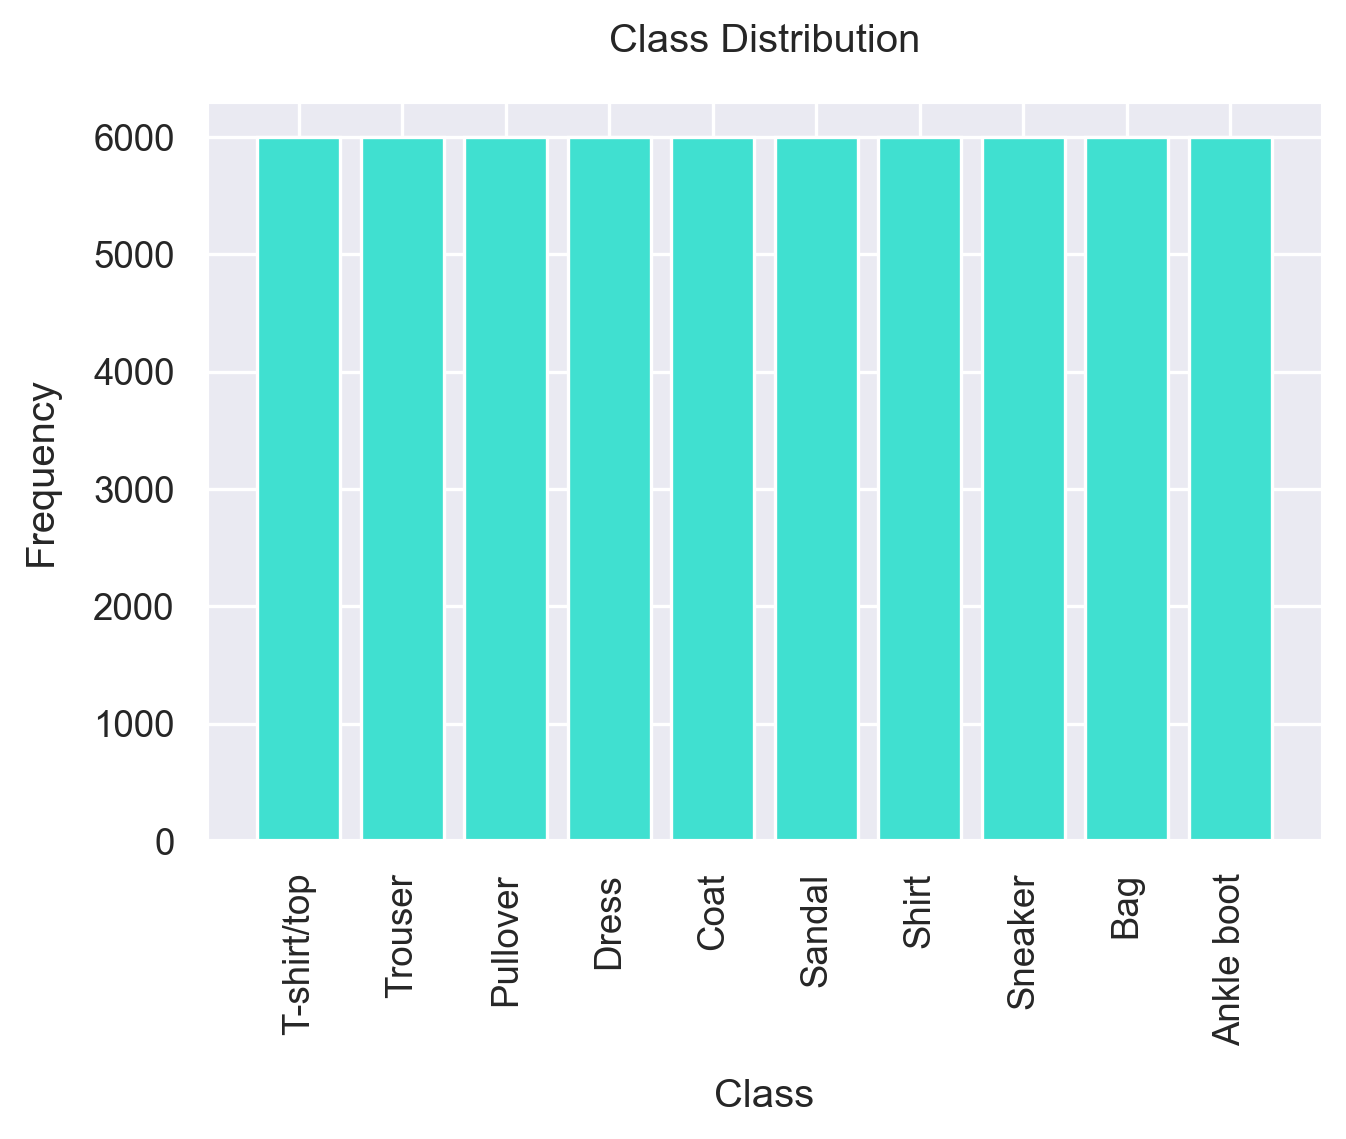

In [5]:
# Define Class Labels
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Plot frequency of each class
freqCount = {k: 0 for k in labels.keys()}

for k in labels.keys():
    freqCount[k] = len(train[train['label'] == k])

sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(6, 4), dpi=240)

plt.bar(freqCount.keys(), freqCount.values(), color='turquoise')
plt.xticks(list(freqCount.keys()), labels.values(), rotation=90)

# Adding labels
plt.title('Class Distribution', pad=15)
plt.xlabel('Class', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.show()

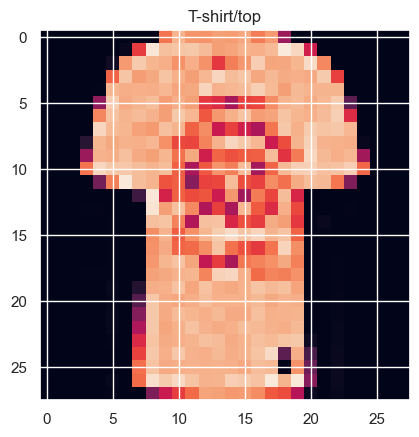

In [6]:
def renderImage(image, label):
    plt.imshow(image.reshape(28,28))
    plt.title(labels[label])
    plt.show()

# Render a random image
randIndex = np.random.randint(0, len(X_train))
renderImage(X_train[randIndex], y_train[randIndex])

We normalize the data by dividing it by 255 so as to convert each pixel value to a number within the 0-1 range. Now our features can be interpreted as the luminosity of a pixel. To train a model on the normalized data, we create 10 dummies or binary variables for each image, with them taking value 1 for the category the image belongs to and 0 otherwise.

In [7]:
# Normalizing the data
X_train = X_train / 255
X_test = X_test / 255

# One-hot encoding the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Multinomial Logistic Regression

A Multinomial Logistic Regression model is one of the most widely used off-the-shelf model for multi-class classification problems. It harnesses the power of Maximum Likelihood Estimation, Gradient Descent and the Softmax function to predict the output class of a given input.

To understand it better, let us start from the basics of linear regression, the formula for which is $h_{\theta}(x) = \theta^T x$, where:

- $\theta^T$ are the weights for our variables/features.
- $x$ is our input data.
- $h_{\theta}(x)$ is a linear score outputted based on the input features.

In Multinomial Logistic Regression, however, we are not predicting a linear score but classifying inputs into multiple categories. We thus have to make use of the softmax function given by:

$$\text{softmax}(\theta^T x)_i = \dfrac{e^{(\theta^T x)_i}}{\sum_{j=1}^{K} e^{(\theta^T x)_j}}$$

Here $e^{(\theta^T x)_i}$ represents the exponential of the linear score for a class $i$, and the denominator is the sum of exponentials of the continuous values for all $K$ classes. $\therefore$ After applying softmax, each class gets a 'probability score', and all scores add up to $1$.

However, we do have to start with the linear model by computing $\theta^T x$, just like in linear regression. We then apply the softmax function and transform our linear output into probabilities for each class. Fundamentally, this is the likelihood that a given input belongs to a particular class. Thus, to determine the best parameters or weights for our model, we can use Maximum Likelihood Estimation (MLE). The best parameters are those that make our observed data most probable. So, to maximize overall log-likelihood, we invert the problem and apply Gradient Descent until we find the best set of parameters.

We will now build this model from scratch.

In [8]:
class MultinomialLogisticRegression:

    def __init__(self, learning_rate=0.01, max_iter=10000, tol=1e-5):

        # Hyperparameters
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol

        self.weights = None
        self.bias = None

    def fit(self, X, y):

        n_samples, n_features = X.shape
        n_classes = y.shape[1]

        # Randomly initialize weights and bias
        self.weights = np.random.randn(n_features, n_classes) * 0.01
        self.bias = np.random.randn(n_classes) * 0.01

        # Loop until convergence or max iterations
        for i in tqdm(range(self.max_iter)):

            # Compute the linear model
            linear_scores = np.dot(X, self.weights) + self.bias

            # Compute the probabilities
            predictions = self.softmax(linear_scores)

            # Compute the gradient using the predictions
            gradient_w = np.dot(X.T, (predictions - y)) / n_samples
            gradient_b = np.sum(predictions - y, axis=0) / n_samples

            # Update weights and bias
            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b

            # Calculate current loss
            loss = self.cross_entropy_loss(y, predictions)

            # Check for convergence
            if i > 0 and abs(prev_loss - loss) < self.tol:
                break

            prev_loss = loss

    def predict(self, X):

        # Compute the linear model with the learned weights and bias
        linear_model = np.dot(X, self.weights) + self.bias

        # Compute the probabilities
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

When fit() is called on any given training data, the following process takes place:

1. Initially, the weights (`self.weights`) and the bias (`self.bias`) are randomized to small values.

2. The function then iterates according to gradient descent, up to a maximum of `self.max_iter` times or until convergence (`tol`: tolerance limit).

3. For each iteration, we calculate scores for each class by multiplying the input data `X` with `weights` and adding the `bias`. The softmax function is applied to these scores which trainsforms then to probabilities.

4. We then compute the gradient of the loss function: `gradient_w` and `gradient_b`, which tells us how to move the weights and bias to reduce the cross-entropy loss. For the sake of this project, we blackbox the cross-entropy loss. However, it is just a measure of a classification model's accuracy and increases as the predicted probability of a observation belonging to it's actual class diverges to other classes. Thus lower the loss, the better the model’s performance. We re-calculate this loss at every iteration.

5. At every iteration we also check if the change in loss is less than `self.tol`. If the model has indeed converged, we stop iterating. If convergence hasn't been achieved, these steps are repeated until convergence or maximum number of iterations is reached.

Once completed, we have the best (well, at least local if not global!) parameters or weights required to predict categories for unseen data.

In [9]:
# Run Logistic Regression
LR_model = MultinomialLogisticRegression()
LR_model.fit(X_train, y_train)

 69%|██████▉   | 6903/10000 [18:48<08:26,  6.12it/s]  


In [10]:
# Evaluate Logistic Regression
predictions = LR_model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), predictions))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1000
           1       0.96      0.94      0.95      1000
           2       0.75      0.74      0.75      1000
           3       0.83      0.87      0.85      1000
           4       0.74      0.81      0.78      1000
           5       0.94      0.85      0.89      1000
           6       0.67      0.57      0.61      1000
           7       0.86      0.89      0.87      1000
           8       0.92      0.94      0.93      1000
           9       0.87      0.93      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



#### Classification Report

1. **Precision:** Precision measures how accurate the predictions are for a given class are, i.e. out of all the predictions made for a class, how many were actually correct.

    - Best: Trouser (Class 1) - At 96% precision, when the model predicts an item as a trouser it is correct most of the time.
    - Worst: Shirt (Class 6) - A precision of 67% indicates a higher chance of misclassifying other items as shirts.

2. **Recall**: Recall measures the model's ability to identify all instances of a particular class.

    - Best: Trouser (Class 1) - With a recall of 94%, the model is highly effective at identifying almost all ankle boots.
    - Worst: Shirt (Class 6) - A recall of 57% for shirts indicates that the model often misses identifying shirts correctly.

3. **F1-Score**: The F1-score combines precision and recall into a single metric, giving a balanced view of the model's performance for each class.

    - Best: Trouser (Class 1) - An F1-score of 0.95 indicates a strong balance between precision and recall.
    - Worst: Shirt (Class 6) - An F1-score of 0.61, indicates that both precision and recall are relatively low for this class.

4. **Overall Accuracy**: The model's overall accuracy is 83%, indicating its average ability to correctly classify an item across all classes.

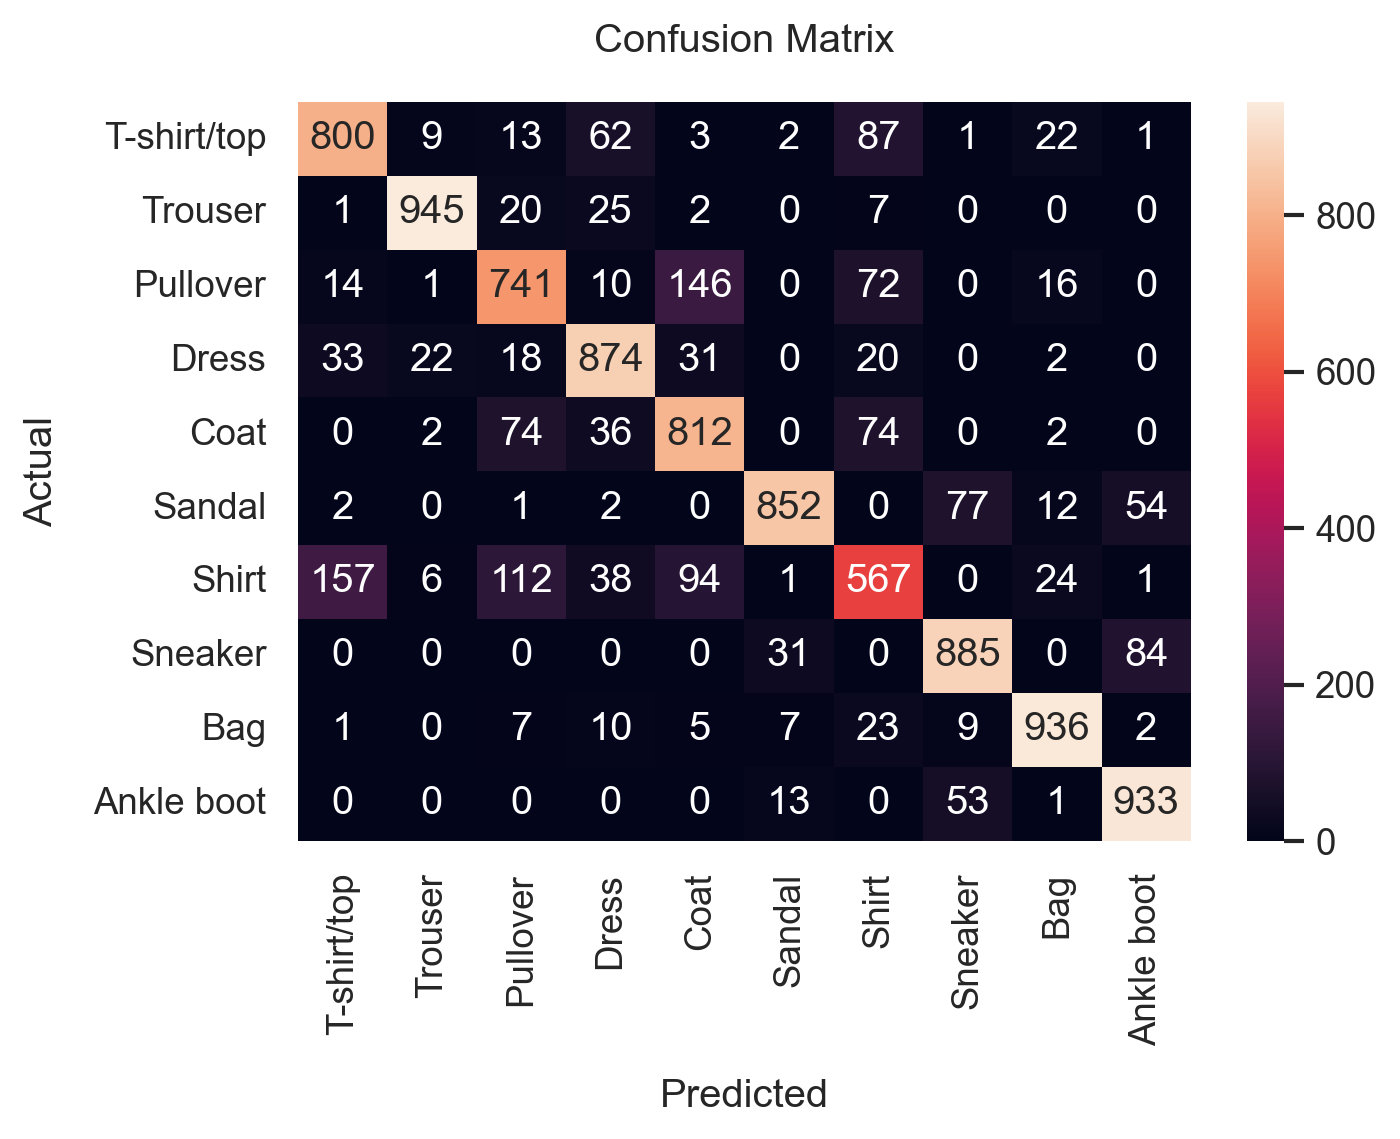

In [11]:
# Plot confusion matrix using seaborn
sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(6, 4), dpi=240)

cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), predictions), annot=True, fmt='g', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix', pad=15)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)
plt.show()

#### Confusion Matrix

A confusion matrix provides insight into misclassifications by displaying how a particular's class identification is distributed across other classes. The value of cell $(i,j)$ with $i,j \in [0,9]$ tells us how many of $i$ clothing items got classified as $j$ by the model.

We can see that our model does well in distinguishing items with unique silhouettes, such as trousers, dresses, bags, and ankle boots. These classes have high true positives and low misclassification rates as well (as can be seen from the report).

**Classes with High Accuracy:**
- Trousers (Class 1) exhibit extremely high accuracy with 945 correct classifications, demonstarting the model's strong ability to identify trousers.
- Bags (Class 8) and Ankle Boots (Class 9) are also well-classified with 936 and 933 correct predictions, respectively, indicating that their distinct shapes are being recognized by the model.

**Classes with Confusion:**
- Shirts (Class 6) show a significant amount of confusion, often being misclassified as T-shirts/tops, Pullovers, or Coats. This makes intuitive sense, since upper clothing garments do look similar in 2-D representations.
- Pullovers (Class 2) also have a similiar problem with many instances misclassified as Coats (Class 4) and T-shirts/tops (Class 0).

**Moderately Performing Classes:**
- T-shirts/tops (Class 0) face confusion with Pullovers and Shirts.
- Dresses (Class 3) have some confusion with T-shirts/tops and Coats, maybe due features like sleeves or length.
- Sandals (Class 5) and Sneakers (Class 7) show some misclassification with each other and Ankle Boots, indicating confusion between footwears.

To improve this model's performance we thus require a more complicated algorithm that can non-linearly combine high dimensional data to generate insights.

### Multi-layer Perceptron

Neural Networks have become increasingly popular in various fields due to their ability to handle multi-modal and complex data, and performing exceptionally well across different tasks. This effectiveness largely stems from their ability to identify and learn from non-linear, complex, and multi-dimensional relationships, much better than other machine learning algorithms.

In our project, we utilize a Multi-Layer Perceptron (MLP), a specific type of neural network that is particularly adept at solving a wide array of classification tasks. Here's a quick overview of how it works:

1. An MLP consists of multiple layers if neurons (also known as nodes). In our MLP model:
   - We start with an input layer which receives the data. The `input_shape` parameter specifies the shape of the input data.
   - Following the input layer, we have a hidden layer. This layer also contains a number of neurons, and here is where majority of the computations occur.
   - The final layer is the output layer with neurons equal to the number of classes (`num_classes`). This layer outputs the final predictions of the network.

2. Neurons in each layer apply an activation function to their input. We use the ReLU activation function, which works very well with non-linearity and can thus solve for complex patterns.
   
3. Similar to multinomial logistic regression, the output layer of our MLP uses the softmax activation function. This function transforms the outputs into probabilities for each $k$ class.

4. Lastly, the model is compiled. This involves selecting an optimizer (we use Adam, an advanced version of stochastic gradient descent), a loss function (categorical_crossentropy), and a metric (accuracy). The optimizer adjusts the weights and biases of neurons during training to minimize the loss.

This approach has clear parallels with our implementation of logistic regression, such as the use of softmax for probability computations, the application of the same loss function, and the use of gradient descent optimization algorithms. Thus making our comparision more robust.**

In [12]:
def MLP(input_shape, num_classes):

    # Define the neural net
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [13]:
input_shape = X_train.shape[1:]  # Input shape of the data
num_classes = y_train.shape[1]   # Number of classes

MLP_model = MLP(input_shape, num_classes)

# Train the model
MLP_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4981 - accuracy: 0.8207 - val_loss: 0.3930 - val_accuracy: 0.8605
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3726 - accuracy: 0.8635 - val_loss: 0.3482 - val_accuracy: 0.8729
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3376 - accuracy: 0.8765 - val_loss: 0.3338 - val_accuracy: 0.8795
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3153 - accuracy: 0.8835 - val_loss: 0.3279 - val_accuracy: 0.8816
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2949 - accuracy: 0.8904 - val_loss: 0.3128 - val_accuracy: 0.8875
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2839 - accuracy: 0.8945 - val_loss: 0.3260 - val_accuracy: 0.8798
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2712 - accuracy: 0.8994 - val_loss: 0.3095 - val_accuracy:

#### Classification Report

In [16]:
# Evaluate the model
loss, accuracy = MLP_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions and generate classification report
predictions = MLP_model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

313/313 [==============================] - 0s 661us/step - loss: 0.3419 - accuracy: 0.8976
Test Accuracy: 89.76%
313/313 [==============================] - 0s 554us/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.88      0.94      0.91      1000
           4       0.85      0.85      0.85      1000
           5       0.99      0.94      0.97      1000
           6       0.78      0.70      0.74      1000
           7       0.95      0.92      0.94      1000
           8       0.97      0.98      0.98      1000
           9       0.91      0.98      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



1. **Precision**

    - **Best**: Trouser (Class 1) - With an almost perfect precision of 99%, the MPL model shows a remarkable improvement over the multinomial logistic regression when predicting trousers.
    - **Worst**: Shirt (Class 6) - Although precision for shirts has improved to 78% with the MLP, this class still has the lowest precision.

2. **Recall**

    - **Best**: Ankle Boot (Class 9) - The recall for ankle boots has increased to 98%, a significant improvement from the logistic regression model, showing that the MLP is highly skilled at identifying almost every ankle boot.
    - **Worst**: Shirt (Class 6) - The recall for shirts has increased to 70%, i.e. a 13 percentage point improvement. However, there are a significant number of instances when MLP fails to classify shirts as well.

3. **F1-Score**

    - **Best**: Trouser (Class 1) - The F1-score for trousers is extremely high at 0.98, reflecting the MLP's better balance of precision and recall compared to the logistic regression.
    - **Worst**: Shirt (Class 6) - The F1-score for shirts has improved to 0.74, which is better than the logistic regression model but still the lowest among the classes.

4. **Overall Accuracy**: The overall accuracy of the MLP model is 90%, a significant increase of 7 percentage points from the 83% accuracy of the logistic regression model.

#### Confusion Matrix

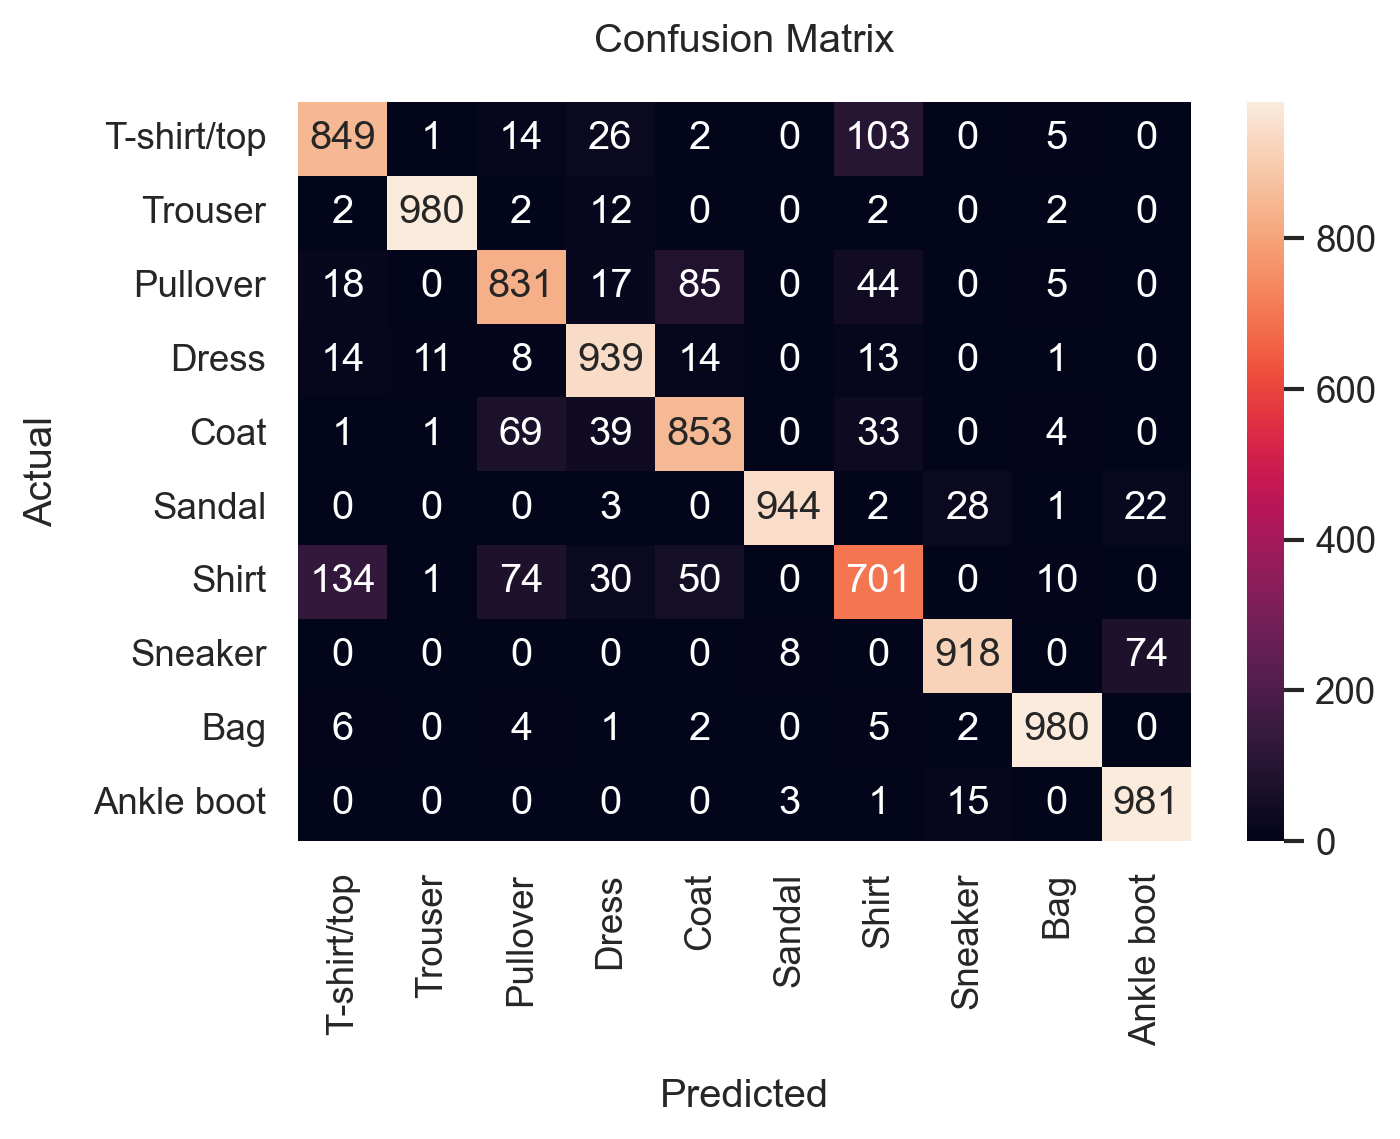

In [18]:
# Plot confusion matrix using seaborn
sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(6, 4), dpi=240)

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt='g', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix', pad=15)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)
plt.show()

**Classes with High Accuracy:**

- Trousers (Class 1) still stand out with exceptionally high accuracy and only a few misclassifications with dresses, indicating that the model can recognize the distinct features of trousers very well.
- Bags (Class 8) and Ankle Boots (Class 9) also reflect high classification accuracies, indicating that their distinct shapes and features remain are well captured by a neural net.
- We see notable improvement in footwear categories (Sandal, Sneaker and Ankle Boots) relative to the multinomial logistic regression cases, which relects the ability of neural nets to capture more complex relationships between features.

**Classes with Confusion:**

- Shirts (Class 6) still have the most notable confusion, often being misclassified as T-shirts/tops, Pullovers, or Coats.
- Pullovers (Class 2) and Coats (Class 4) also experience the same problem, with the model mixing them up for each other or other upper clothing garments.

**Moderately Performing Classes:**

- Other items are well-classified but do seem to have some confusion with similar garment types, as indicated by the off-diagonal numbers. But overall, the accuaries are much higer and there is more concentrated confusion (a positive!) than the previous case.

### Bayesian Neural Network

Due to `theano`, `pymc3` and `tensorflow` dependency incompababilities, we set up a different virtual environment for the Bayesian Neural Network code. Please refer to the BNN notebook.